### Standard BiLSTM Model with feature engineered data

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping
from IPython.display import display, HTML
import lime.lime_tabular
import shap

/Users/amalshar/miniforge3/envs/mlenv64/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('/Users/amalshar/Desktop/USD/Fall 2025/Data Analysis/Final Project/daily_2025_engineered_data.csv')

In [3]:
# Define features and target
FEATURES = ['CO', 'SO2', 'NO2', 'O3', 'PM25',
            'BarometricPressure', 'Temperature', 'WindResultant',
            'month', 'dayofweek', 'is_weekend', 'dayofyear',
            'CO_roll_3', 'NO2_roll_3', 'PM25_roll_3', 'O3_roll_3']

TARGET = 'DailyAQI'

X = df[FEATURES].values
y = df[TARGET].values.reshape(-1, 1)

In [4]:
# Scaling
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

In [5]:
# Create 7-day lookback sequences
def create_sequences(X, y, time_steps=7):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 7
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps)
print("X_seq shape:", X_seq.shape)

X_seq shape: (91733, 7, 16)


In [6]:
# Train-test split
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

print("Train Shape:", X_train.shape)
print("Test Shape:", X_test.shape)

Train Shape: (73386, 7, 16)
Test Shape: (18347, 7, 16)


In [7]:
# Build BiLSTM model
model = Sequential([
    Input(shape=(time_steps, len(FEATURES))),
    Bidirectional(LSTM(64, activation='relu', return_sequences=True)),
    BatchNormalization(),
    Bidirectional(LSTM(32, activation='relu')),
    BatchNormalization(),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 7, 128)         │        41,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,521 (326.25 KB)

 Trainable params: 83,137 (324.75 KB)

 Non-trainable params: 384 (1.50 KB)

In [8]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
918/918 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - loss: 0.0201 - val_loss: 0.0032
Epoch 2/100
918/918 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - loss: 0.0017 - val_loss: 9.3190e-04
Epoch 3/100
918/918 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 9.0014e-04 - val_loss: 0.0011
Epoch 4/100
918/918 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 5.9973e-04 - val_loss: 4.2880e-04
Epoch 5/100
918/918 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - loss: 5.0429e-04 - val_loss: 4.3734e-04
Epoch 6/100
918/918 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - loss: 4.2072e-04 - val_loss: 4.3746e-04
Epoch 7/100
918/918 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - loss: 3.8532e-04 - val_loss: 4.9039e-04
Epoch 8/100
918/918 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - loss: 3.6963e-04 - val_loss: 5.4044e-04
Epoch 9/100
918/918 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - loss: 3.5057e-04 - val_loss: 4.6517e-04
Epoch 10/100
918/918 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - loss: 3.3310e-04 - val_loss: 4.0911e-04
Epoch 11/100
918/918 ━━━━━━━━━━━━━━━━━━━━ 16s

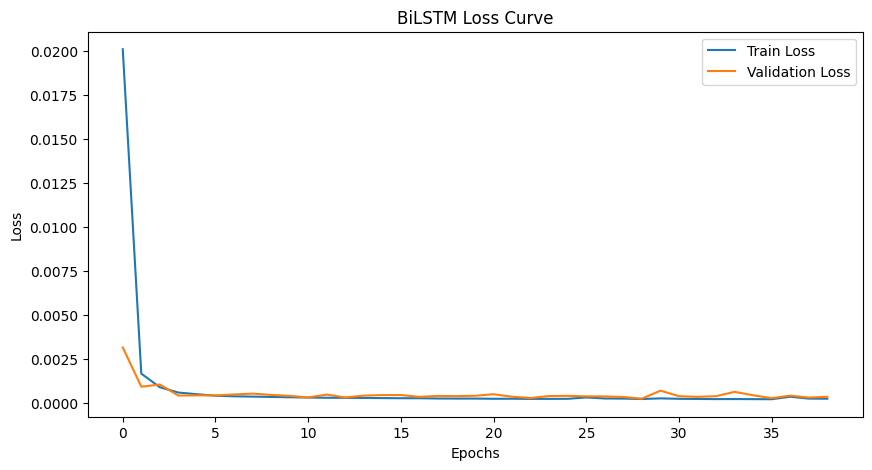

In [9]:
# Loss curve
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('BiLSTM Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
# Predictions
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test)

# Evaluation
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R-squared (R²): {r2:.3f}")

574/574 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
Mean Squared Error (MSE): 3560.198
Root Mean Squared Error (RMSE): 59.667
Mean Absolute Error (MAE): 23.682
Mean Absolute Percentage Error (MAPE): inf%
R-squared (R²): -0.006


/var/folders/rx/gyp8p3vs42zfzk_hwhrnpcmw0000gn/T/ipykernel_61142/1400119000.py:10: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100


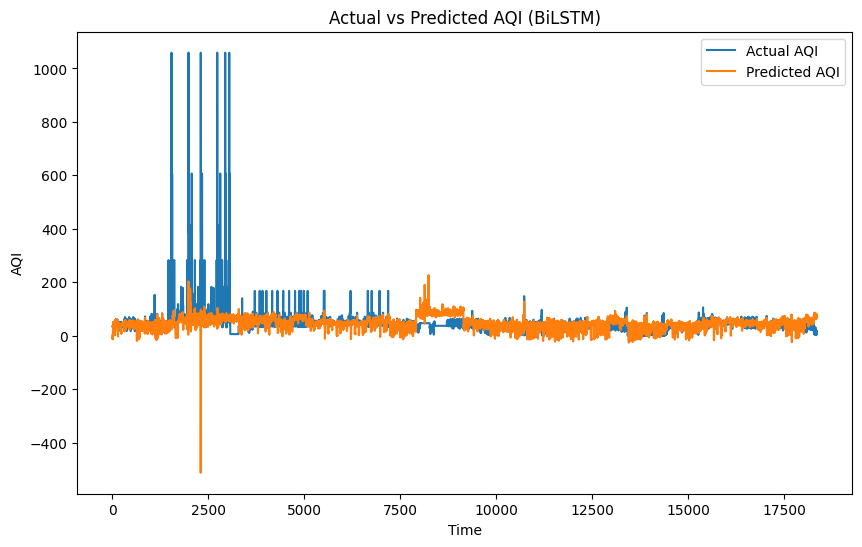

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(y_true, label='Actual AQI')
plt.plot(y_pred, label='Predicted AQI')
plt.title('Actual vs Predicted AQI (BiLSTM)')
plt.xlabel('Time')
plt.ylabel('AQI')
plt.legend()
plt.show()

574/574 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
574/574 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
574/574 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
               Feature  Importance
4                 PM25    0.056666
9            dayofweek    0.041083
8                month    0.022241
11           dayofyear    0.021115
10          is_weekend    0.019518
0                   CO    0.003815
7        WindResultant    0.003268
3                   O3 

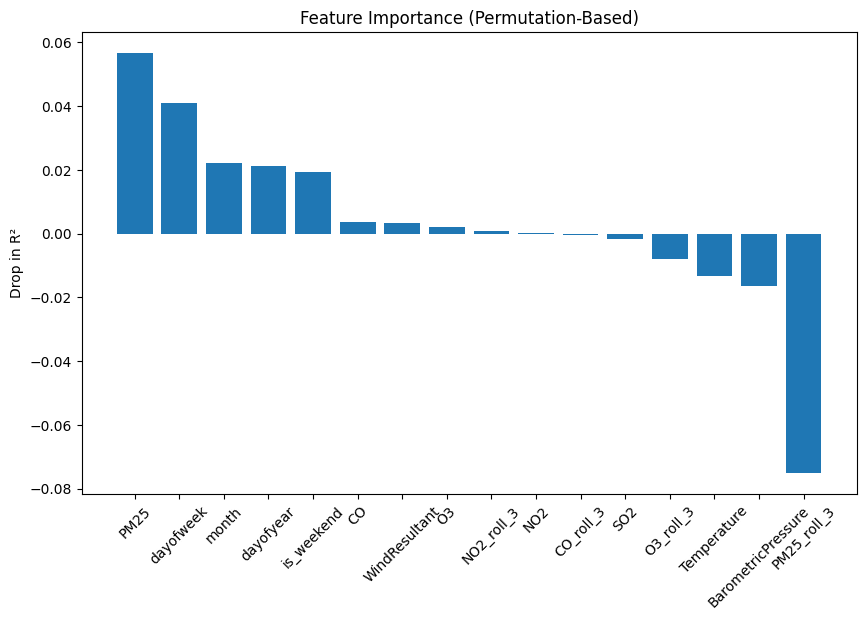

In [12]:
from sklearn.inspection import permutation_importance

def permutation_importance_bilstm(model, X_test, y_true, metric=r2_score):
    baseline_pred = scaler_y.inverse_transform(model.predict(X_test))
    baseline_score = metric(y_true, baseline_pred)

    importances = {}
    for i, feat in enumerate(FEATURES):
        X_test_perm = X_test.copy()
        
        for t in range(time_steps):
            np.random.shuffle(X_test_perm[:, :, i])
        
        perm_pred = scaler_y.inverse_transform(model.predict(X_test_perm))
        perm_score = metric(y_true, perm_pred)
        importances[feat] = baseline_score - perm_score

    return importances

feat_importances = permutation_importance_bilstm(model, X_test, y_true)

sorted_importances = pd.DataFrame(
    feat_importances.items(), columns=['Feature', 'Importance']
).sort_values(by='Importance', ascending=False)

print(sorted_importances)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(sorted_importances['Feature'], sorted_importances['Importance'])
plt.title('Feature Importance (Permutation-Based)')
plt.xticks(rotation=45)
plt.ylabel('Drop in R²')
plt.show()


In [16]:
# Flatten for LIME
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

feature_names = [f"{feat}_t-{i}" for i in range(time_steps) for feat in FEATURES]

def predict_wrapper(flat_data):
    reshaped = flat_data.reshape(-1, time_steps, len(FEATURES))
    return model.predict(reshaped).flatten()

lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_flat,
    feature_names=feature_names,
    mode='regression'
)

# Create LIME explanation
i = 0
exp = lime_explainer.explain_instance(
    data_row=X_test_flat[i],
    predict_fn=predict_wrapper,
    num_features=10
)

# Display the result
try:
    from IPython.display import display, HTML
    display(HTML(exp.as_html()))
except ImportError:
    # Fallback to console output
    print("LIME Explanation:")
    for feature, weight in exp.as_list():
        print(f"{feature}: {weight}")
        
# save LIME explanation to HTML file
with open("exp11_lime_explanation.html", "w") as f:
    f.write(exp.as_html())


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 10%|█         | 1/10 [00:00<00:07,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 20%|██        | 2/10 [00:02<00:09,  1.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 30%|███       | 3/10 [00:03<00:08,  1.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 40%|████      | 4/10 [00:05<00:07,  1.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 50%|█████     | 5/10 [00:06<00:06,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 60%|██████    | 6/10 [00:07<00:05,  1.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


 70%|███████   | 7/10 [00:09<00:04,  1.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


 80%|████████  | 8/10 [00:10<00:02,  1.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 90%|█████████ | 9/10 [00:11<00:01,  1.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


100%|██████████| 10/10 [00:12<00:00,  1.23s/it]


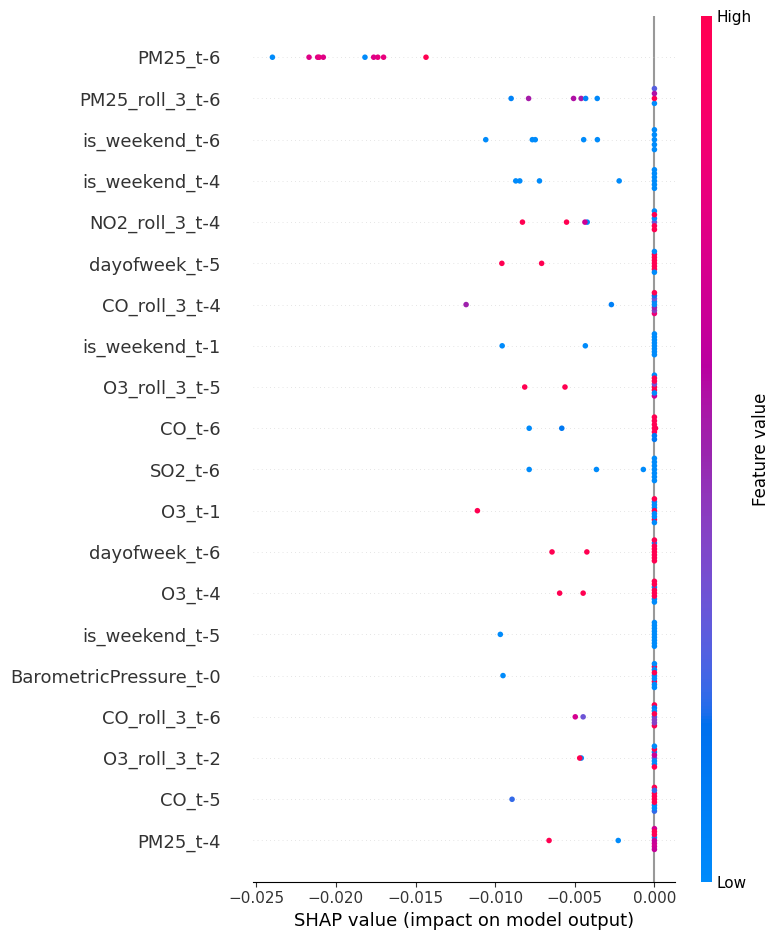

In [17]:
background = X_train_flat[:100]
test_samples = X_test_flat[:10]
shap_explainer = shap.KernelExplainer(predict_wrapper, background)
shap_values = shap_explainer.shap_values(test_samples, nsamples=100)

shap.summary_plot(shap_values, test_samples, feature_names=feature_names)